# 3D Lables EDA

Explor file structure, data structure and lables of our 3D images of mouse skulls and explore some of the issue facing the product development.

---

We are using the `nibabel` package to read the `.mnc` files

In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization!
import numpy as np

In [14]:
img = nib.load("/Users/michaeldac/Code/CUNY/698/Skulls/475.mnc")

In [15]:
data = img.get_data()
print("The data shape is:", data.shape)
print("The type of data is:", type(data))
np.set_printoptions(precision=2, suppress=True)
print(data[0:4, 0:4, 0:4])

The data shape is: (698, 397, 456)
The type of data is: <class 'numpy.ndarray'>
[[[-242.   -186.99 -304.03 -101.02]
  [ -59.98 -216.98 -267.03  -55.02]
  [  31.01   29.98 -118.01   68.97]
  [ -35.98  230.02  337.03  221.01]]

 [[-179.02  -62.    148.97  143.02]
  [ -72.02    7.98   93.98   99.02]
  [  59.02  125.    152.    146.  ]
  [  64.     -3.98  -45.98   40.99]]

 [[   8.03  128.02  128.99  -11.  ]
  [  92.01  181.01   90.02    1.02]
  [  88.99   41.98 -118.01  -69.98]
  [ 137.02   43.98 -114.99  -23.03]]

 [[-117.    -31.99  -94.99  -12.  ]
  [ 103.03   32.02 -155.98  -89.  ]
  [  -3.99   32.02 -208.   -107.98]
  [ 208.03  132.99 -178.99   26.98]]]


In the small slice of the 3d numpy array show the data structure where brighter pixles are of a higher number.

Unlike many photos these allow negative value instead of having a scale of 0-255. More invistigation needs to be done to find out what the best way to scale these for a neural network are.

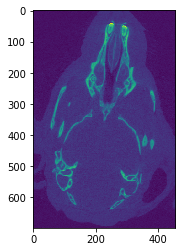

In [38]:
img_data = img.get_fdata()


def show_slices(slices):
    """Function to show image slices"""
    fig, axes = plt.subplot(1, len(slices), 1)
    i=0
    for s in slices:
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        i+=1

slice_0 = img_data[350, :, :]
slice_1 = img_data[:, 200, :]
slice_2 = img_data[:, :, 225]
#show_slices([slice_0, slice_1, slice_2])
# plt.suptitle("Center slices for EPI image")  # doctest: +SKIP


plt.imshow(slice_1)
plt.show()


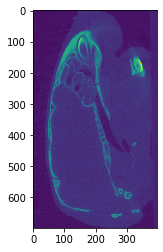

In [17]:
plt.imshow(slice_2)
plt.show()


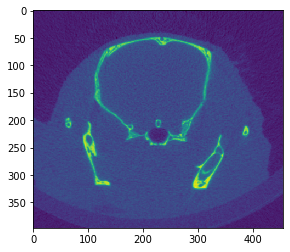

In [18]:
plt.imshow(slice_0)
plt.show()


The above images show three cross sections of the mouse skull.


In [2]:
import pandas as pd
from io import StringIO
from ThreeDLabeler.preprocessing import tag_parser

In [20]:
tags = tag_parser('/Users/michaeldac/Code/CUNY/698/Skulls/475_landmarks.tag')
tags

array([[13.65,  7.05, 14.94],
       [10.07,  9.49,  8.1 ],
       [ 9.73,  5.17,  0.57],
       [ 6.82,  9.39,  7.67],
       [ 1.93,  6.43, 13.68]])

In [21]:
tags.shape

(5, 3)

In [34]:
img_475 = (data, tags)
img_475_array = img_475[0]
img_476 = (data, tags)

In [42]:
pd.DataFrame([img_475, img_476])

,0,1
0,"[[[-242.00209048599982, -186.98965438315395, -...","[[13.6525859832764, 7.04926586151123, 14.94253..."
1,"[[[-242.00209048599982, -186.98965438315395, -...","[[13.6525859832764, 7.04926586151123, 14.94253..."


In [43]:
np.save('img_475.npy', img_475)

In [45]:
reload = np.load('img_475.npy', allow_pickle=True)
reload

array([array([[[-242.  , -186.99, -304.03, ..., -147.03,  -44.01,   49.99],
        [ -59.98, -216.98, -267.03, ..., -114.99,  -61.  ,  114.98],
        [  31.01,   29.98, -118.01, ...,   33.97,    9.  ,  134.99],
        ...,
        [  66.98,   68.01,  162.01, ..., -140.98, -155.01, -135.  ],
        [ -85.97, -127.02,   81.97, ...,  -31.02,  121.02,   40.98],
        [ -81.01,  -64.99,   16.01, ...,  121.02,  158.99,    9.  ]],

       [[-179.02,  -62.  ,  148.97, ..., -146.98,   66.  ,  156.98],
        [ -72.02,    7.98,   93.98, ...,  -26.98,  104.  ,  312.  ],
        [  59.02,  125.  ,  152.  , ...,   68.  ,  263.99,  385.01],
        ...,
        [  -3.01,  -34.02,  146.  , ..., -119.  ,   34.01,   59.99],
        [ -22.01,   47.98,  164.02, ...,   66.  ,   91.01,    3.97],
        [  36.99,   91.01,  171.97, ...,  232.97,  267.02,   95.98]],

       [[   8.03,  128.02,  128.99, ...,   63.98,  -67.01,    8.99],
        [  92.01,  181.01,   90.02, ...,  -96.98, -218.  ,  -65.02

The 3D images are accompanied by `.tag` files that denote the `(x, y, z)` cordinates of key points measured in mm. There are currently only 4 points as initially we are only trying to orientate the mouse skulls in space.

---

To match these to the points on an our images we need to find out how large the voxels (3D pixles) are:


In [22]:
print("The voxel size is:", img.header.get_zooms(), 'mm in each dimension')

The voxel size is: (0.035, 0.035, 0.035) mm in each dimension


Therefore, we can divide the point location by the voxel size to get the points in space of the key points for this image.

In [23]:
pixel_loc = np.round(tags / 0.035)
pixel_loc

array([[390., 201., 427.],
       [288., 271., 232.],
       [278., 148.,  16.],
       [195., 268., 219.],
       [ 55., 184., 391.]])

In [ ]:
data

When plotted on the skull image we can see that these points pertain to the left and right eyes, left and right front molars and the tip of the nose. 

These are used to orientate the skull in 3D space in order to make labeling easier.

In [ ]:
def mri_point_plot(img, df, dim_cols=['x', 'z'], iter_cols='y'):
    """Graphs an points. pt_cols is used to set the cols to iterate 
    over (different views)
    """
    
    ax = []
    fig = plt.figure(figsize=(9, 8))
    columns = 3
    rows = 2

    for i in df.index:
        y_slice = int(df.loc[i, iter_cols])
        im = img[:, y_slice, :]
        ax.append( fig.add_subplot(rows, columns, i+1))
        ax[-1].set_title("Image depth: "+str(y_slice))  # set title
        plt.imshow(im)
        plt.plot(df.loc[i, dim_cols[0]], df.loc[i, dim_cols[1]], 'ro')
    plt.show()




Another example of a skull:

In [ ]:
img2 = nib.load("/Users/michaeldac/Code/CUNY/698/Skulls/930.mnc")
tags2 = tag_parser("/Users/michaeldac/Code/CUNY/698/Skulls/930_landmarks.tag")



pix_size = img2.header.get_zooms()
print(pix_size)
img2 = img2.get_data()


tags2 = tags2 / pix_size[0]

mri_point_plot(img2, tags2)

In [ ]:
img2 = nib.load("MouseSkullData/943.mnc")
tags2 = tag_parser("MouseSkullData/943_landmarks.tag")



pix_size = img2.header.get_zooms()
print(pix_size)
img2 = img2.get_data()


tags2 = tags2 / pix_size[0]

mri_point_plot(img2, tags2)

In [26]:
img2 = nib.load("/Users/michaeldac/Code/CUNY/698/Skulls/1837.mnc")
tags2 = tag_parser("/Users/michaeldac/Code/CUNY/698/Skulls/1837_landmarks.tag")



pix_size = img2.header.get_zooms()
print(pix_size)
img2 = img2.get_data()


tags2 = tags2 / pix_size[0]

mri_point_plot(img2, tags2)

FileNotFoundError: No such file or no access: '/Users/michaeldac/Code/CUNY/698/Skulls/1837.mnc'

# Explor image size

The actual image data when stored as a numpy array is huge at around 1 Gb

In [ ]:
import sys
sys.getsizeof(img_data)

In [ ]:
print(round(sys.getsizeof(img_data) / 1e9, 2), "Gb")

Further, we need to be concerned at the dimensions of the images and the voxel size. The image dimensions are important because many deep learning algorithms require a uniform image input size. Further we will most likely have to scale the images down in order to be abel to perform and not overfit on such highly dimensional data. 

The voxel size is also important because our scales are denoted in milimeters and we need to match them to the appropritate location even with scaling.

In [ ]:
import os
from tqdm import tqdm

files = os.listdir('/Users/michaeldac/Code/CUNY/698/Skulls')

In [42]:
mnc_files = [f for f in files if 'mnc' in f]

In [45]:
img_dims = {}
for i in tqdm(mnc_files):
    dims = nib.load(str('/Users/michaeldac/Code/CUNY/698/Skulls/' + i)).header.get_data_shape()
    img_dims[i] = dims

dim_df = pd.DataFrame.from_dict(img_dims).T
dim_df.columns = ['x', 'y', 'z']

100%|██████████| 5/5 [00:00<00:00, 59.85it/s]


In [46]:
dim_df.head()

,x,y,z
475.mnc,698,397,456
930.mnc,661,441,422
717_2_8.mnc,510,464,395
711_2_6.mnc,299,473,552
717_2_6.mnc,279,602,384


In [48]:
img_res = {}
for i in tqdm(mnc_files):
    res = nib.load(str('/Users/michaeldac/Code/CUNY/698/Skulls/' + i)).header.get_zooms()
    img_res[i] = res
    
res_df = pd.DataFrame.from_dict(img_res).T
res_df.columns = ['x', 'y', 'z']

100%|██████████| 5/5 [00:00<00:00, 66.46it/s]


In [49]:
res_df.head()

,x,y,z
475.mnc,0.035,0.035,0.035
930.mnc,0.035,0.035,0.035
717_2_8.mnc,0.035,0.035,0.035
711_2_6.mnc,0.035,0.035,0.035
717_2_6.mnc,0.035,0.035,0.035


In [50]:
res_df.loc[res_df.x != 0.035]

,x,y,z


In [51]:
dim_df.describe()

,x,y,z
count,5.000000,5.000000,5.000000
mean,489.400000,475.400000,441.800000
std,196.153766,76.637458,67.581062
min,279.000000,397.000000,384.000000
25%,299.000000,441.000000,395.000000
50%,510.000000,464.000000,422.000000
75%,661.000000,473.000000,456.000000
max,698.000000,602.000000,552.000000


In [25]:
dim_df.loc[dim_df.y == 888]

,x,y,z
bh_cc_aa0839_skull.mnc,556,888,586


So we can see that the voxel size is almost always `0.035` however there are some images that differ. Further outside of this intial training example we can expect the voxel sizes to differ considerably. Thus we need a solution to scale to whatever size is inputted. 

----

We also need to pick an image ratio to pad our images to. The issue is that the dimensions are not all even xor odd. This means that adding a uniform band around one side of an image will not be an option. Instead the image band or pad size will have to be different by one pixel in approximately half of the specimens.

In [5]:
img = nib.load("/Users/michaeldac/Code/CUNY/698/Skulls/475.mnc")
data = img.get_data()
tags = tag_parser("/Users/michaeldac/Code/CUNY/698/Skulls/475_landmarks.tag")
pixel_loc = np.round(tags / 0.035)


In [7]:
from ThreeDLabeler import images

from ThreeDLabeler.preprocessing import tag_parser
from ThreeDLabeler.plotting import mri_point_plot
# importlib.reload(ThreeDLabeler.images)

im = images.Image(data, (0.035, 0.035, 0.035), tags)


In [8]:
im.voxels

array([[[-242.00209049, -186.98965438, -304.0264744 , ...,
         -147.02725261,  -44.01432822,   49.99137865],
        [ -59.97648585, -216.97570764, -267.02847333, ...,
         -114.98892195,  -61.00262455,  114.98016327],
        [  31.00781262,   29.98167391, -118.01033036, ...,
           33.97221332,    9.00283818,  134.98986801],
        ...,
        [  66.97967498,   68.00581369,  162.01152056, ...,
         -140.9844358 , -155.00833143, -134.99862669],
        [ -85.97199969, -127.01754788,   81.97270161, ...,
          -31.0165713 ,  121.02298009,   40.98416114],
        [ -81.01232929,  -64.99316396,   16.01478599, ...,
          121.02298009,  158.99011215,    9.00283818]],

       [[-179.02105745,  -62.00343328,  148.97161822, ...,
         -146.97711147,   66.00068666,  156.98260472],
        [ -72.0171664 ,    7.97825589,   93.98191806, ...,
          -26.98397803,  103.99565118,  311.99519341],
        [  59.01968414,  124.99588006,  152.00434882, ...,
           68.

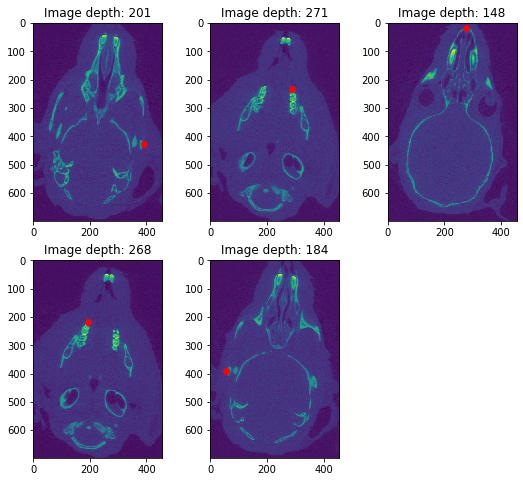

In [14]:
mri_point_plot(im.voxels, im.point_positon)

In [15]:
im.cube()

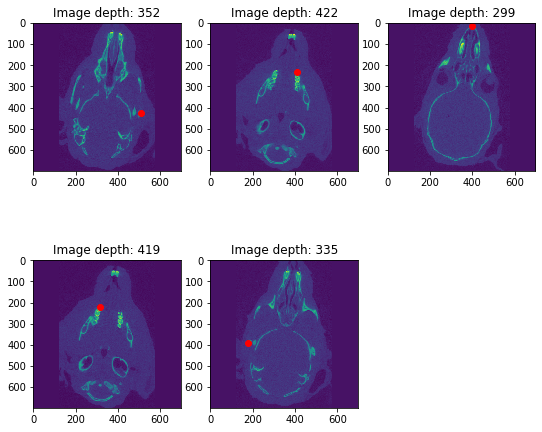

In [16]:
mri_point_plot(im.voxels, im.point_positon)

In [ ]:
im.voxels

In [17]:
im.scale(128)

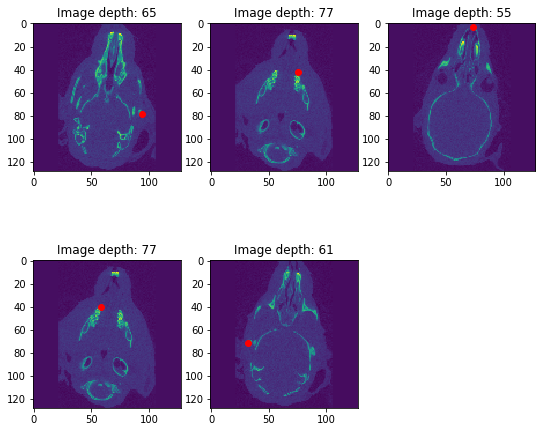

In [18]:
mri_point_plot(im.voxels, im.point_positon)

In [22]:
reduced_475 = (im.voxels, tags)

In [23]:
np.save('475_reduced.npy', reduced_475)

In [24]:
import os
os.getcwd()

'/Users/michaeldac/Code/CUNY/698/3DLabeler'

In [21]:
reload_475 = np.load('475_reduced.npy', allow_pickle=True)
reload_475

array([array([[[-9.53285316e-170, -1.46218544e-165,  5.42729030e-164, ...,
         -1.10760442e-164,  2.87236274e-166,  1.71757826e-170],
        [-9.71978087e-166, -8.84462007e-148,  9.28904770e-146, ...,
         -1.20926094e-146,  1.15140474e-148,  1.93612676e-166],
        [ 5.80057534e-163,  9.28904770e-146, -9.75580708e-144, ...,
          1.27002432e-144, -1.20926094e-146, -5.88774060e-165],
        ...,
        [-2.37654397e-162, -8.43363162e-146,  8.85740775e-144, ...,
          5.57564715e-144, -5.30888443e-146,  3.99564334e-163],
        [ 1.23413596e-165,  8.03013075e-148, -8.43363162e-146, ...,
         -5.30888443e-146,  5.05488477e-148,  1.00170156e-165],
        [ 8.56622903e-170,  1.52080581e-165, -2.33637797e-163, ...,
          9.85932905e-163,  1.46297588e-165, -5.71281788e-169]],

       [[-6.31995620e-169,  1.17366511e-165, -4.20041965e-164, ...,
         -7.64861783e-164,  1.29920771e-165, -4.81972837e-171],
        [ 4.36629273e-166,  1.31483743e-148, -1.380905

In [57]:
print(im.point_positon)
print(im.voxels.shape)

            x           y           z
0  232.418142  367.391886  209.743568
1  167.890644  170.798370  217.475128
2   17.093248   38.742730   98.710006
3  230.083738   86.600549  183.602006
4  420.789582  121.969904   94.993544
(299, 473, 552)


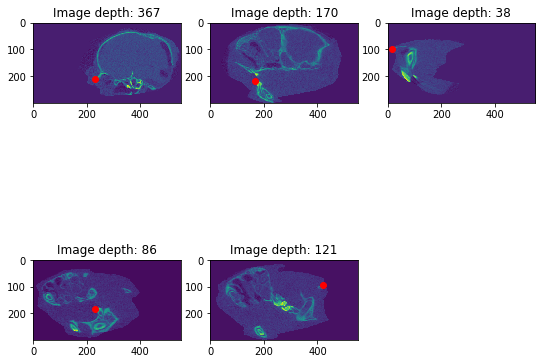

In [58]:
mri_point_plot(im.voxels, im.point_positon)

In [59]:
im.cube()

In [60]:
print(im.point_positon)
print(im.voxels.shape)

            x           y           z
0  232.418142  407.391886  336.743568
1  167.890644  210.798370  344.475128
2   17.093248   78.742730  225.710006
3  230.083738  126.600549  310.602006
4  420.789582  161.969904  221.993544
(552, 552, 552)


In [12]:
im.scale(128)
type(im)

NameError: name 'im' is not defined

In [62]:
print(im.point_positon)
print(im.voxels.shape)

           x          y          z
0  53.894062  94.467684  78.085465
1  38.931164  48.880781  79.878291
2   3.963652  18.259184  52.338552
3  53.352751  29.356649  72.023654
4  97.574396  37.558239  51.476764
(128, 128, 128)


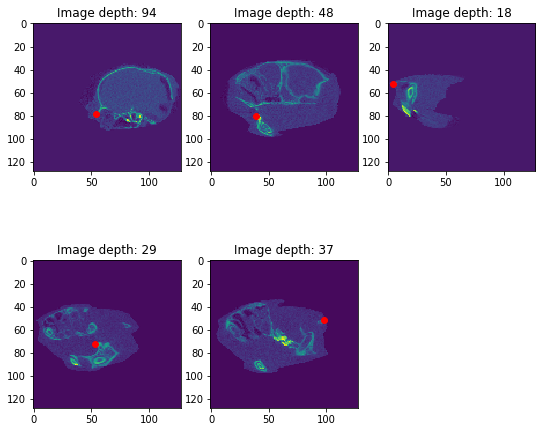

In [63]:
mri_point_plot(im.voxels, im.point_positon)

We can see this is positioning 